# CH4 extra stuff

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({'figure.figsize': (8, 6)})   # good for screen
RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/lm/interpreting"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)


## Partial regression plots

Imported from [42_multiple_linear_regression.ipynb](./42_multiple_linear_regression.ipynb)

In [4]:

# int_weed = b0 +b_alc*means["alc"]+b_exrc*means["exrc"]
# print(f"weed intercept={int_weed}, weed slope={b_weed}")
# weeds = np.linspace(0, doctors["weed"].max())
# scorehats_weed = int_weed + b_weed*weeds
# sns.lineplot(x=weeds, y=scorehats_weed)
# sns.scatterplot(data=doctors, x="weed", y="score");

# int_exrc = b0 +b_alc*means["alc"]+b_weed*means["weed"]
# print(f"exrc intercept={int_exrc}, exrc slope={b_exrc}")
# weeds = np.linspace(0, doctors["weed"].max())
# scorehats_weed = int_weed + b_weed*weeds
# sns.lineplot(x=weeds, y=scorehats_weed)
# sns.scatterplot(data=doctors, x="weed", y="score");


# # Partial models for individual variables  (NOT THE SAME)
# with plt.rc_context({"figure.figsize":(12,3)}):
#     fig, (ax1,ax2,ax3) = plt.subplots(1,3)
#     sns.regplot(data=doctors, x="alc", y="score",  ci=None, ax=ax1)
#     sns.regplot(data=doctors, x="weed", y="score", ci=None, ax=ax2)
#     sns.regplot(data=doctors, x="exrc", y="score", ci=None, ax=ax3)
# # smf.ols("score ~ 1 + alc", data=doctors).fit().params.values, \
# # smf.ols("score ~ 1 + weed", data=doctors).fit().params.values, \
# # smf.ols("score ~ 1 + exrc", data=doctors).fit().params.values


In [5]:
# # ALT2. When exog_others is not empty, subtracts influence of others from both predictor and outcome
# from statsmodels.graphics.api import plot_partregress
# with plt.rc_context({"figure.figsize":(12,3)}):
#     fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
#     plot_partregress("score", "alc",  exog_others=["weed", "exrc"], data=doctors, obs_labels=False, ax=ax1)
#     plot_partregress("score", "weed", exog_others=["alc", "exrc"], data=doctors, obs_labels=False, ax=ax2)
#     plot_partregress("score", "exrc", exog_others=["alc", "weed"], data=doctors, obs_labels=False, ax=ax3)

In [6]:
# ALT2B. Same as ALT2. but done in one shot
# from statsmodels.graphics.api import plot_partregress_grid
# plot_partregress_grid(lm2, ["alc", "weed", "exrc"], grid=(1,3));

In [7]:
def simple_regplot(x, y, n_std=2, n_pts=100, ax=None,
                   scatter_kws=None, line_kws=None, ci_kws=None):
    """
    Draw a regression line with error interval.
    via https://stackoverflow.com/a/59756979/127114
    See also https://github.com/ttesileanu/pydove/blob/main/pydove/regplot.py
    """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(y, x_fit).fit()

    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and error interval
    ci_kws = {} if ci_kws is None else ci_kws
    ax.fill_between(
        eval_x[:, 1],
        pred.predicted_mean - n_std * pred.se_mean,
        pred.predicted_mean + n_std * pred.se_mean,
        alpha=0.5,
        **ci_kws,
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x[:, 1], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(x, y, c=h[0].get_color(), **scatter_kws)

    return fit_results

/var/folders/wc/2r44j8gs4gn56t1xtw5f6wlm0000gn/T/ipykernel_29046/3264559806.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=h[0].get_color(), **scatter_kws)


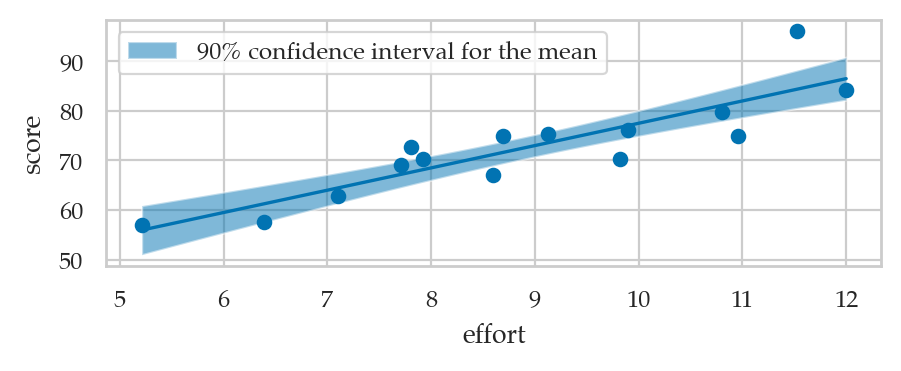

In [8]:
# SUPERSEDED BY plot_lm_simple(efforts, scores, ci_mean=True, alpha_mean=0.1)
from scipy.stats import t as tdist

students = pd.read_csv("../datasets/students.csv")
efforts = students["effort"]
scores = students["score"]

n_std = tdist(df=13).ppf(0.05)
simple_regplot(efforts, scores, n_std=n_std, ci_kws={"label":"90% confidence interval for the mean"})
plt.legend()

plt.xlabel("effort")
plt.ylabel("score");

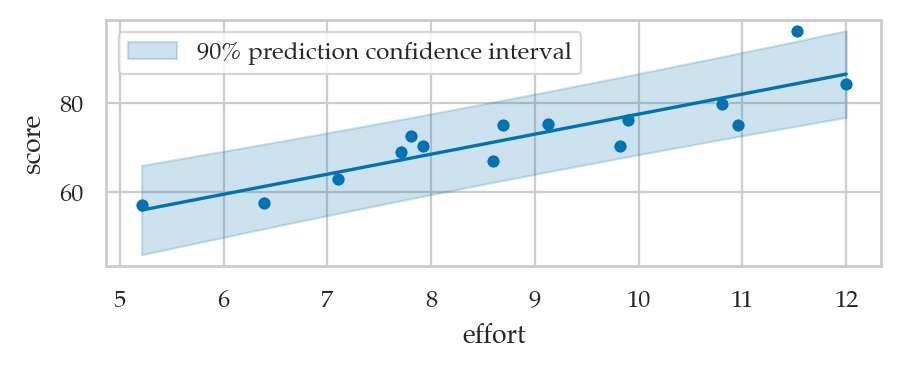

In [9]:
# SUPERSEDED BY plot_lm_simple(efforts, scores, ci_obs=True, alpha_obs=0.1)
# via https://discuss.python.org/t/whats-the-meaning-of-this-confidence-bands/14445/9
sstudents = students.sort_values("effort")
efforts = sstudents["effort"]
scores = sstudents["score"]
x = efforts
y = scores
n = len(efforts)

# calculate interval manually using the formula
lm1 = smf.ols("score ~ 1 + effort", data=students).fit()
b0 = lm1.params["Intercept"]  # = lm1.params[0]
b1 = lm1.params["effort"]     # = lm1.params[1]
SSR = np.sum(lm1.resid**2)
sigmahat = np.sqrt( SSR / (n-2) )
a, b = b0, b1
y_est = b0 + b1*x

xdevsq = (x - x.mean())**2
sxdevsq = np.sum((x - x.mean())**2)
se_yhat = sigmahat * np.sqrt( 1 + 1/n + xdevsq/sxdevsq )

fig, ax = plt.subplots()

# plot manually calculated interval (std interval) --- the blue one
sns.scatterplot(data=students, x="effort", y="score", ax=ax)
ax.plot(x, y_est, '-')
alpha = 0.1
tstar = tdist(df=13).ppf(alpha/2)
ax.fill_between(x, y_est - tstar*se_yhat, y_est + tstar*se_yhat, alpha=0.2, color="C0", label="90% prediction confidence interval")
ax.legend(loc="upper left")

plt.xlabel("effort")
plt.ylabel("score");

### Sheffé bands (several different ways)

Text(0, 0.5, 'Y')

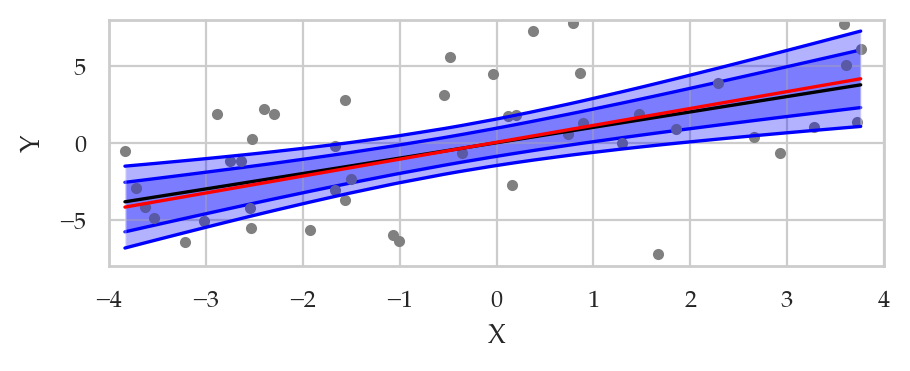

In [10]:
# via https://stackoverflow.com/a/26672416/127114
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

## Sample size.
n = 50

## Predictor values.
XV = np.random.uniform(low=-4, high=4, size=n)
XV.sort()

## Design matrix.
X = np.ones((n,2))
X[:,1] = XV

## True coefficients.
beta = np.array([0, 1.], dtype=np.float64)

## True response values.
EY = np.dot(X, beta)

## Observed response values.
Y = EY + np.random.normal(size=n)*np.sqrt(20)

## Get the coefficient estimates.
u,s,vt = np.linalg.svd(X,0)
v = np.transpose(vt)
bhat = np.dot(v, np.dot(np.transpose(u), Y)/s)

## The fitted values.
Yhat = np.dot(X, bhat)

## The MSE and RMSE.
MSE = ((Y-EY)**2).sum()/(n-X.shape[1])
s = np.sqrt(MSE)

## These multipliers are used in constructing the intervals.
XtX = np.dot(np.transpose(X), X)
V = [np.dot(X[i,:], np.linalg.solve(XtX, X[i,:])) for i in range(n)]
V = np.array(V)

## The F quantile used in constructing the Scheffe interval.
QF = sp.fdtri(X.shape[1], n-X.shape[1], 0.95)
QF_2 = sp.fdtri(X.shape[1], n-X.shape[1], 0.68)

## The lower and upper bounds of the Scheffe band.
D = s*np.sqrt(X.shape[1]*QF*V)
LB,UB = Yhat-D,Yhat+D
D_2 = s*np.sqrt(X.shape[1]*QF_2*V)
LB_2,UB_2 = Yhat-D_2,Yhat+D_2


## Make the plot.
plt.clf()
plt.plot(XV, Y, 'o', ms=3, color='grey')
# plt.hold(True)
a = plt.plot(XV, EY, '-', color='black', zorder = 4)

plt.fill_between(XV, LB_2, UB_2, where = UB_2 >= LB_2, facecolor='blue', alpha= 0.3, zorder = 0)
b = plt.plot(XV, LB_2, '-', color='blue', zorder=1)
plt.plot(XV, UB_2, '-', color='blue', zorder=1)

plt.fill_between(XV, LB, UB, where = UB >= LB, facecolor='blue', alpha= 0.3, zorder = 2)
b = plt.plot(XV, LB, '-', color='blue', zorder=3)
plt.plot(XV, UB, '-', color='blue', zorder=3)

d = plt.plot(XV, Yhat, '-', color='red',zorder=4)

plt.ylim([-8,8])
plt.xlim([-4,4])

plt.xlabel("X")
plt.ylabel("Y")

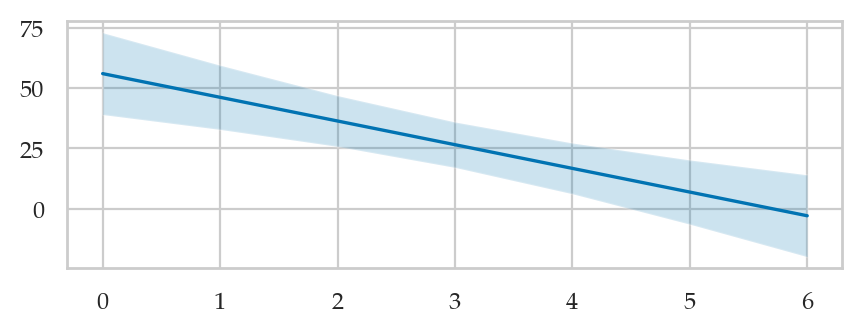

In [11]:
# via https://discuss.python.org/t/whats-the-meaning-of-this-confidence-bands/14445/9
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

x = np.arange(7)
y = np.array([101,12,7,32,11,21,2])
n = x.size

# calculate interval manually using the formula
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = (y-y_est).std() * np.sqrt(1/n + (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots()

# plot manually calculated interval (std interval) --- the blue one
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)

# plot seaborn calculated interval (std interval, i.e. when ci=68.27) --- the orange one
# sns.regplot(x=x, y=y, ci=68.27)

# plt.text(3.5,90,'blue one: using formula\norange one: using seaborn')
# plt.show()

Optimal Values
a: 0.036141582292222356
b: -0.5735680960487426
R^2: 0.5278048667629538
Uncertainty
a: 0.0361+/-0.0035
b: -0.57+/-0.07


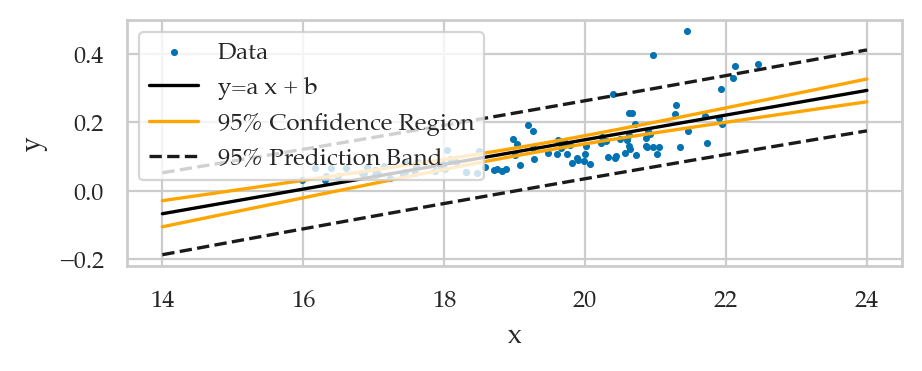

In [12]:
# via https://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics
# see also https://www.youtube.com/watch?v=r4pgGD1kpYM
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt    
from scipy import stats
import pandas as pd

# pip install uncertainties, if needed
try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    try:
        from pip import main as pipmain
    except:
        from pip._internal import main as pipmain
    pipmain(['install','uncertainties'])
    import uncertainties.unumpy as unp
    import uncertainties as unc

# import data
url = 'http://apmonitor.com/che263/uploads/Main/stats_data.txt'
data = pd.read_csv(url)
x = data['x'].values
y = data['y'].values
n = len(y)

def f(x, a, b):
    return a * x + b

popt, pcov = curve_fit(f, x, y)

# retrieve parameter values
a = popt[0]
b = popt[1]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))

# compute r^2
r2 = 1.0 - ( sum((y-f(x,a,b))**2) / ((n-1.0)*np.var(y,ddof=1)) )
print('R^2: ' + str(r2))

# calculate parameter confidence interval
a, b = unc.correlated_values(popt, pcov)
print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))

# plot data
plt.scatter(x, y, s=3, label='Data')

# calculate regression confidence interval
px = np.linspace(14, 24, 100)
py = a*px + b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0 + (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

lpb, upb = predband(px, x, y, popt, f, conf=0.95)

# plot the regression
plt.plot(px, nom, c='black', label='y=a x + b')

# uncertainty lines (95% confidence)
plt.plot(px, nom - 1.96 * std, c='orange', label='95% Confidence Region')
plt.plot(px, nom + 1.96 * std, c='orange')
# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='best')

Text(0, 0.5, 'Y')

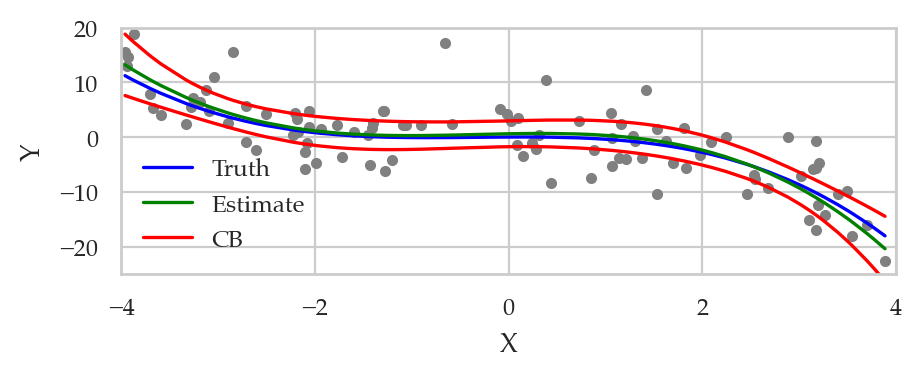

In [13]:
# via https://en.m.wikipedia.org/wiki/File:Polyreg_scheffe.svg
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

## Sample size.
n = 100

## Predictor values.
XV = np.random.uniform(low=-4, high=4, size=n)
XV.sort()

## Design matrix.
X = np.ones((n,4))
X[:,1] = XV
X[:,2] = XV**2
X[:,3] = XV**3

## True coefficients.
beta = np.array([0, 0.1, -0.25, -0.25], dtype=np.float64)

## True response values.
EY = np.dot(X, beta)

## Observed response values.
Y = EY + np.random.normal(size=n)*np.sqrt(20)

## Get the coefficient estimates.
u,s,vt = np.linalg.svd(X,0)
v = np.transpose(vt)
bhat = np.dot(v, np.dot(np.transpose(u), Y)/s)

## The fitted values.
Yhat = np.dot(X, bhat)

## The MSE and RMSE.
MSE = ((Y-EY)**2).sum()/(n-X.shape[1])
s = np.sqrt(MSE)

## These multipliers are used in constructing the Scheffe interval.
XtX = np.dot(np.transpose(X), X)
V = [np.dot(X[i,:], np.linalg.solve(XtX, X[i,:])) for i in range(n)]
V = np.array(V)

## The F quantile used in constructing the Scheffe interval.
QF = sp.fdtri(X.shape[1], n-X.shape[1], 0.95)

## The lower and upper bounds of the confidence band.
D = s*np.sqrt(X.shape[1]*QF*V)
LB,UB = Yhat-D,Yhat+D

## Make the plot.
plt.clf()
plt.plot(XV, Y, 'o', ms=3, color='grey')
plt.plot(XV, EY, '-', color='blue', label = "Truth")
plt.plot(XV, Yhat, '-', color='green', label = "Estimate")
plt.plot(XV, LB, '-', color='red', label = "CB")
plt.plot(XV, UB, '-', color='red')
plt.legend(frameon=False)
plt.ylim([-25,20])
plt.gca().set_yticks([-20,-10,0,10,20])
plt.xlim([-4,4])
plt.gca().set_xticks([-4,-2,0,2,4])
plt.xlabel("X")
plt.ylabel("Y")

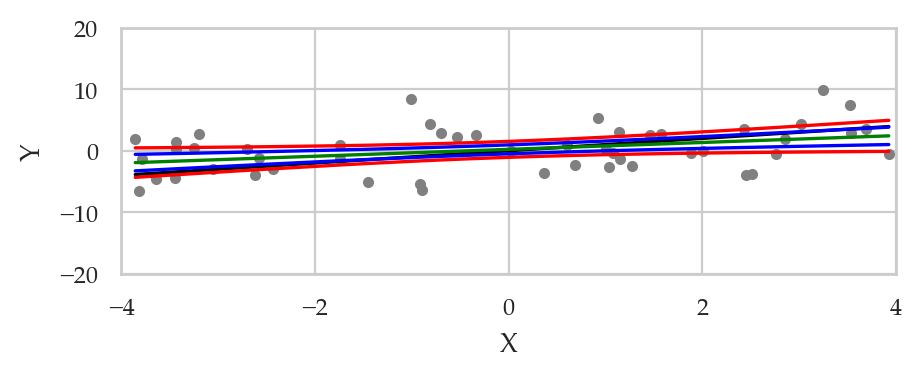

In [14]:
# via https://en.wikipedia.org/wiki/File:Regression_confidence_band.svg
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

## Sample size.
n = 50

## Predictor values.
XV = np.random.uniform(low=-4, high=4, size=n)
XV.sort()

## Design matrix.
X = np.ones((n,2))
X[:,1] = XV

## True coefficients.
beta = np.array([0, 1.], dtype=np.float64)

## True response values.
EY = np.dot(X, beta)

## Observed response values.
Y = EY + np.random.normal(size=n)*np.sqrt(20)

## Get the coefficient estimates.
u,s,vt = np.linalg.svd(X,0)
v = np.transpose(vt)
bhat = np.dot(v, np.dot(np.transpose(u), Y)/s)

## The fitted values.
Yhat = np.dot(X, bhat)

## The MSE and RMSE.
MSE = ((Y-EY)**2).sum()/(n-X.shape[1])
s = np.sqrt(MSE)

## These multipliers are used in constructing the intervals.
XtX = np.dot(np.transpose(X), X)
V = [np.dot(X[i,:], np.linalg.solve(XtX, X[i,:])) for i in range(n)]
V = np.array(V)

## The F quantile used in constructing the Scheffe interval.
QF = sp.fdtri(X.shape[1], n-X.shape[1], 0.95)

## The lower and upper bounds of the Scheffe band.
D = s*np.sqrt(X.shape[1]*QF*V)
LB,UB = Yhat-D,Yhat+D

## The lower and upper bounds of the pointwise band.
D = s*np.sqrt(2*V)
LBP,UBP = Yhat-D,Yhat+D

## Make the plot.
plt.clf()
plt.plot(XV, Y, 'o', ms=3, color='grey')
# plt.hold(True)
a = plt.plot(XV, EY, '-', color='black')
b = plt.plot(XV, LB, '-', color='red')
plt.plot(XV, UB, '-', color='red')
c = plt.plot(XV, LBP, '-', color='blue')
plt.plot(XV, UBP, '-', color='blue')
d = plt.plot(XV, Yhat, '-', color='green')
# B = plt.legend( (a,d,b,c), ("Truth", "Estimate", "95% simultaneous CB", "95% pointwise CB") )
# B.draw_frame(False)
plt.ylim([-20,15])
plt.gca().set_yticks([-20,-10,0,10,20])
plt.xlim([-4,4])
plt.gca().set_xticks([-4,-2,0,2,4])
plt.xlabel("X")
plt.ylabel("Y");

## Model predictive accuracy

### L1 regularization

Optimal LASSO Alpha: 0.483293
Optimized LASSO   MSE: 88.547 R2: 0.998
Linear Regression MSE: 118.439 R2: 0.999


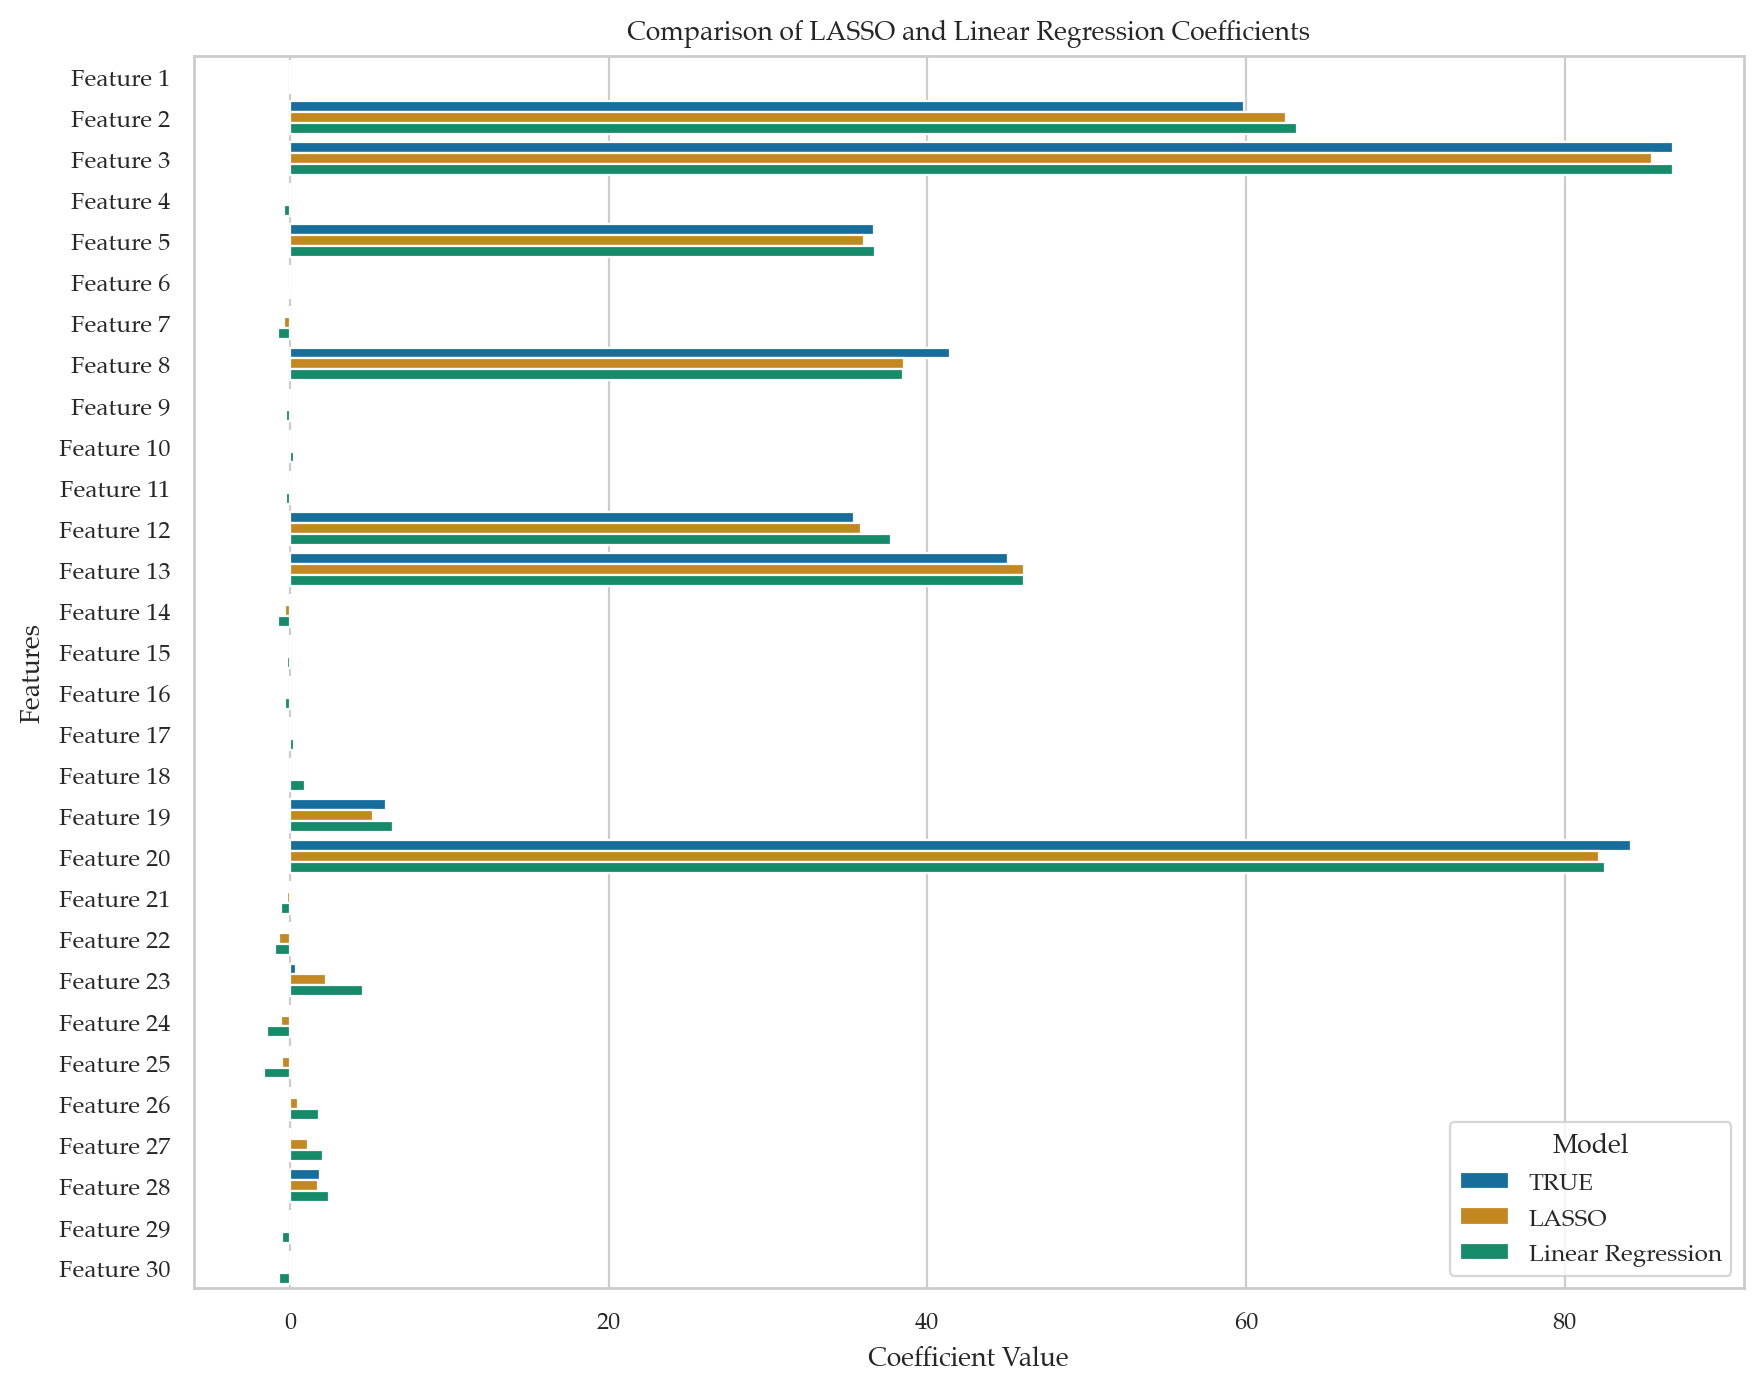

In [15]:
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.datasets import make_regression
import numpy as np

# Generating the dataset based on your specifications
X, y, coefs = make_regression(n_samples=70, n_features=30, n_informative=10, noise=10, random_state=43, coef=True)

# Optimizing LASSO alpha with cross-validation
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 20), cv=5).fit(X, y)
optimal_alpha = lasso_cv.alpha_

# Instantiating LASSO with the optimized alpha
lasso_opt = Lasso(alpha=optimal_alpha)
lasso_opt.fit(X, y)  # Fitting the LASSO model

# Instantiating and fitting Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(X, y)

# Evaluating optimized LASSO using LOOCV
loo = LeaveOneOut()
lasso_opt_scores = cross_val_score(lasso_opt, X, y, cv=loo, scoring='neg_mean_squared_error')
lasso_opt_mse = -np.mean(lasso_opt_scores)

# Evaluating Linear Regression using LOOCV
linear_regression_scores = cross_val_score(linear_regression, X, y, cv=loo, scoring='neg_mean_squared_error')
linear_regression_mse = -np.mean(linear_regression_scores)

# Printing MSE and coefficients
print(f"Optimal LASSO Alpha: {optimal_alpha:.6f}")
print(f"Optimized LASSO   MSE: {lasso_opt_mse:.3f}",         f"R2: {lasso_opt.score(X,y):.3f}")
print(f"Linear Regression MSE: {linear_regression_mse:.3f}", f"R2: {linear_regression.score(X,y):.3f}")

# Comparing coefficients
# print("\nCoefficients comparison:")
# list(zip(np.round(coefs,3),
#          np.round(lasso_opt.coef_,3),
#          np.round(linear_regression.coef_,3) ))


# Assuming the models have already been fit with the data

# Preparing the data for plotting
coefficients = pd.DataFrame({
    'Feature': [f'Feature {i}' for i in range(1, 31)],  # Adjust based on your number of features
    'TRUE': coefs,
    'LASSO': lasso_opt.coef_,
    'Linear Regression': linear_regression.coef_
})

# Melting the DataFrame for easier plotting with Seaborn
coefficients_melted = coefficients.melt(id_vars=['Feature'], var_name='Model', value_name='Coefficient')

# Creating the plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', hue='Model', data=coefficients_melted, orient='h')

plt.title('Comparison of LASSO and Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features');

In [16]:
# %pip install biokit

In [17]:
# from biokit.viz import corrplot
# doctors = pd.read_csv("../datasets/doctors.csv")
# c = corrplot.Corrplot(doctors[["alc", "weed", "exrc"]])
# c.plot();

In [18]:
# c.plot(method='square');

In [19]:
doctors = pd.read_csv("../datasets/doctors.csv")


#### Check the correlation matrix

In [20]:
corrM = doctors[["alc", "weed", "exrc","score"]].corr()
corrM.round(2)

,alc,weed,exrc,score
alc,1.00,0.04,0.03,-0.82
weed,0.04,1.00,0.10,-0.06
exrc,0.03,0.10,1.00,0.38
score,-0.82,-0.06,0.38,1.00


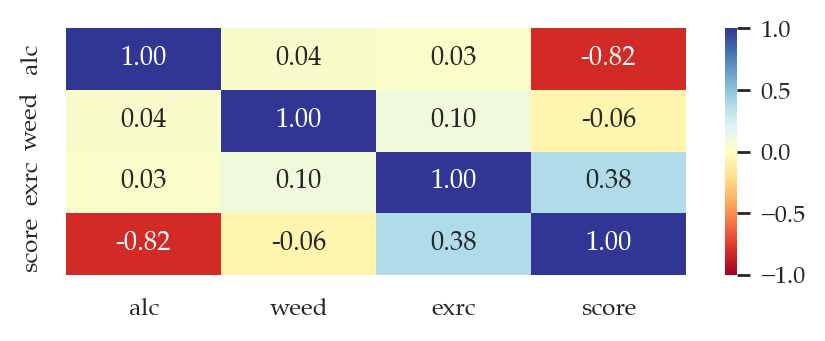

In [21]:
from matplotlib import colors
divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
sns.heatmap(corrM, annot=True, fmt='.2f', cmap="RdYlBu", norm=divnorm);

### Other model fit metrics

In [22]:
formula = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula, data=doctors).fit()

# model degrees of freedom (number of predictors)
p = lm2.df_model


In [23]:
# Explained sum of squares
lm2.ess

54570.51590209804

In [24]:
lm2.ssr / (n-4),   lm2.mse_resid

(222.33438116955202, 67.28540482762759)

In [25]:
scores = doctors["score"].values
scoreshat = lm2.fittedvalues.values
meanscore = np.mean(scores)

In [26]:
# TSS = Total Sum of Squares
tss = sum( (scores-meanscore)**2 )
lm2.centered_tss, tss

(64797.89743589744, 64797.8974358974)

In [27]:
# SSR = Sum of Squares Residuals
ssr = sum( (scores-scoreshat)**2 )
ssr, lm2.ssr

(10227.381533799391, 10227.381533799393)

In [28]:
# ESS = Explained Sum of Squares
ess = sum( (scoreshat-meanscore)**2 ) 
lm2.ess, ess

(54570.51590209804, 54570.515902097904)

In [29]:
# MSE
from statsmodels.tools.eval_measures import mse
mse(scores, scoreshat), lm2.ssr/n

(65.56013803717558, 204.54763067598785)

In [30]:
# RMSE
from statsmodels.tools.eval_measures import rmse

rmse(scores, scoreshat), np.sqrt(lm2.ssr/n)

(8.096921516056307, 14.30201491664681)

In [31]:
# MAE
from statsmodels.tools.eval_measures import meanabs

mae = sum( np.abs(scores - scoreshat) ) / n
meanabs(scores, scoreshat), mae

(6.41593242149194, 20.017709155054845)

In [32]:
# MAPE (cuttable)
mape = sum( np.abs(scores - scoreshat)/scores ) / n
mape

0.6937156810553234

In [33]:
# Mean squared error the model
# The explained sum of squares divided by the model degrees of freedom
lm2.mse_model, lm2.ess/3

(18190.171967366015, 18190.171967366015)

In [34]:
# Mean squared error of the residuals
# The sum of squared residuals divided by the residual degrees of freedom.
lm2.mse_resid, lm2.ssr/(n-4)

(67.28540482762759, 222.33438116955202)

In [35]:
# Total mean squared error
# The centered total sum of squares divided by the number of observations.
lm2.mse_total, lm2.centered_tss/(n-1)

(418.05095119933833, 1322.406070120356)

#### Partial residual plot

component-plus-residual plot

/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.9/site-packages/statsmodels/graphics/regressionplots.py:1199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  focus_val = results.params[focus_col] * model.exog[:, focus_col]


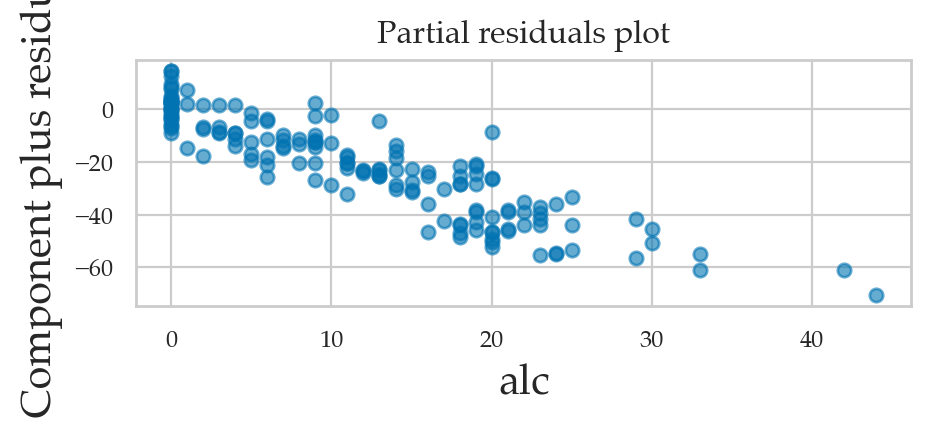

In [36]:
from statsmodels.graphics.regressionplots import plot_partial_residuals

plot_partial_residuals(lm2, "alc");

### Predictions (skipping because covered in Sec 4.1)

The predction 

In [37]:
new_data = {"alc":3, "weed":1, "exrc":8}
lm2.predict(new_data)

0    68.177355
dtype: float64

In [38]:
pred_score = lm2.get_prediction(new_data)

In [39]:
# observation  +  90% CI
pred_score.predicted,                     # predicted value
pred_score.se_obs,                        # pred. std error
pred_score.conf_int(obs=True, alpha=0.1)  # 90% CI for value

array([[54.50324518, 81.85146489]])

In [40]:
# # ALT.
# from scipy.stats import t as tdist
# obs_dist = tdist(df=pred_score.df, loc=pred_score.predicted, scale=pred_score.se_obs)
# obs_dist.ppf(0.05), obs_dist.ppf(0.95)

In [41]:
pred_score.predicted_mean,                 # predicted mean
pred_score.se_mean,                        # pred. mean std error
pred_score.conf_int(obs=False, alpha=0.1)  # 90% CI for the mean

array([[66.53473577, 69.81997431]])

In [42]:
# # ALT.
# from scipy.stats import t as tdist
# mean_dist = tdist(df=pred_score.df, loc=pred_score.predicted, scale=pred_score.se_mean)
# mean_dist.ppf(0.05), mean_dist.ppf(0.95)

In [43]:
ac_casino_path = "../../Inspiration/Data/Winner_datasets/data/ac_casino.dat"
column_names = ["Year", "Profit", "Slot Handle", "Table Drop"]
ac_casino = pd.read_fwf(ac_casino_path, names=column_names, header=0)
ac_casino.head()

,Year,Profit,Slot Handle,Table Drop
0,1979,1.5065,1.0053,1.0234
1,1980,1.6789,1.9935,2.2880
2,1981,2.7484,3.3707,3.6867
3,1982,3.7131,5.0657,4.7145
4,1983,5.2408,6.7658,5.4286



## Players dataset

In [44]:
players_full = pd.read_csv("../datasets/players_full.csv")

### Plot of linear model for `time ~ 1 + age`

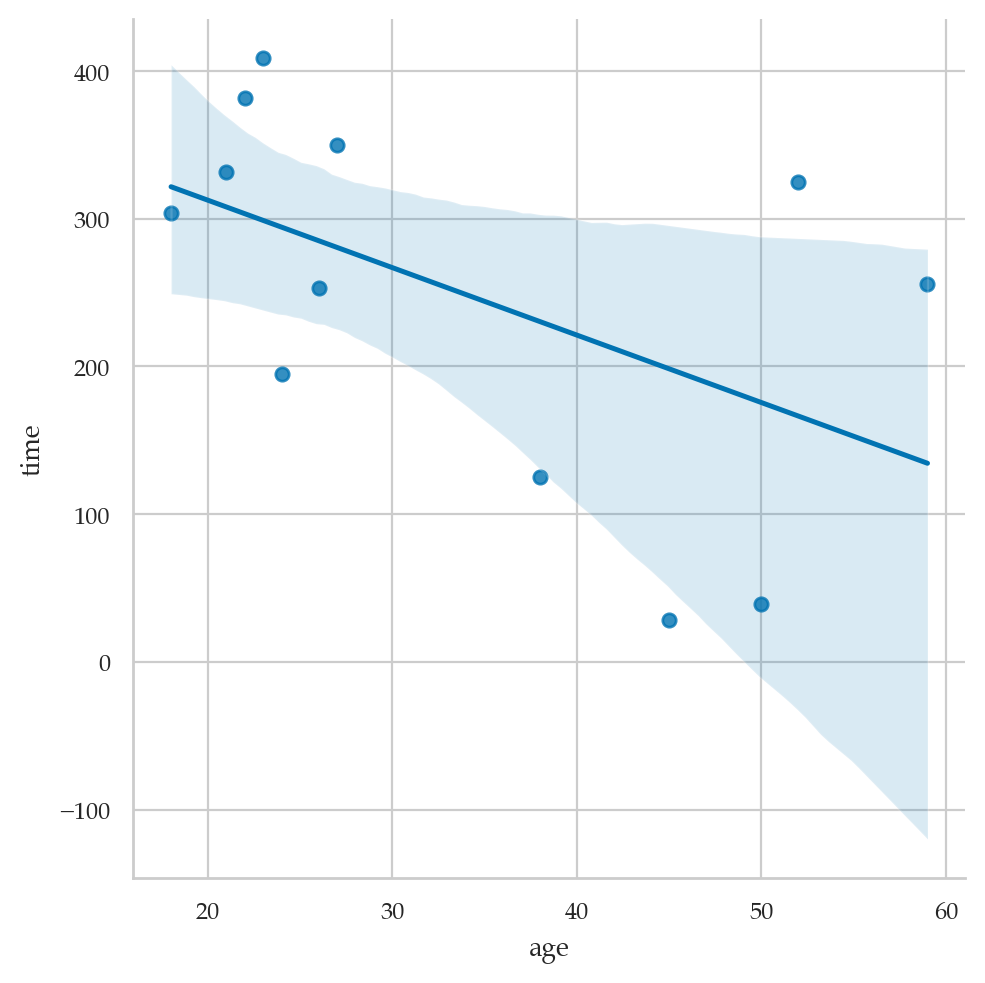

In [45]:
sns.lmplot(x="age", y="time", data=players_full)

In [46]:
import statsmodels.formula.api as smf

model1 = smf.ols('time ~ 1 + age', data=players_full)
result1 = model1.fit()
result1.summary()

/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     3.516
Date:                Thu, 04 Jul 2024   Prob (F-statistic):             0.0902
Time:                        16:19:58   Log-Likelihood:                -72.909
No. Observations:                  12   AIC:                             149.8
Df Residuals:                      10   BIC:                             150.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    403.8531     88.666      4.555      0.001     206.292     601.414
age           -4.5658      2.435     -1.875      0.090      -9.991       0.859
==============================================================================
Omnibus:                        2.175   Durbin-Watson:                   2.490
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                0.930
Skew:                          -0.123   Prob(JB):                        0.628
Kurtosis:                       1.659   Cond. No.                         97.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plot of linear model for `time ~ 1 + age + jobstatus`

We can "control for `jobstatus`" by including the variable in the linear model.
Essentially,
we're fitting two separate models,
one for `jobstatus=0` players and one for `jobstatus=1` players.


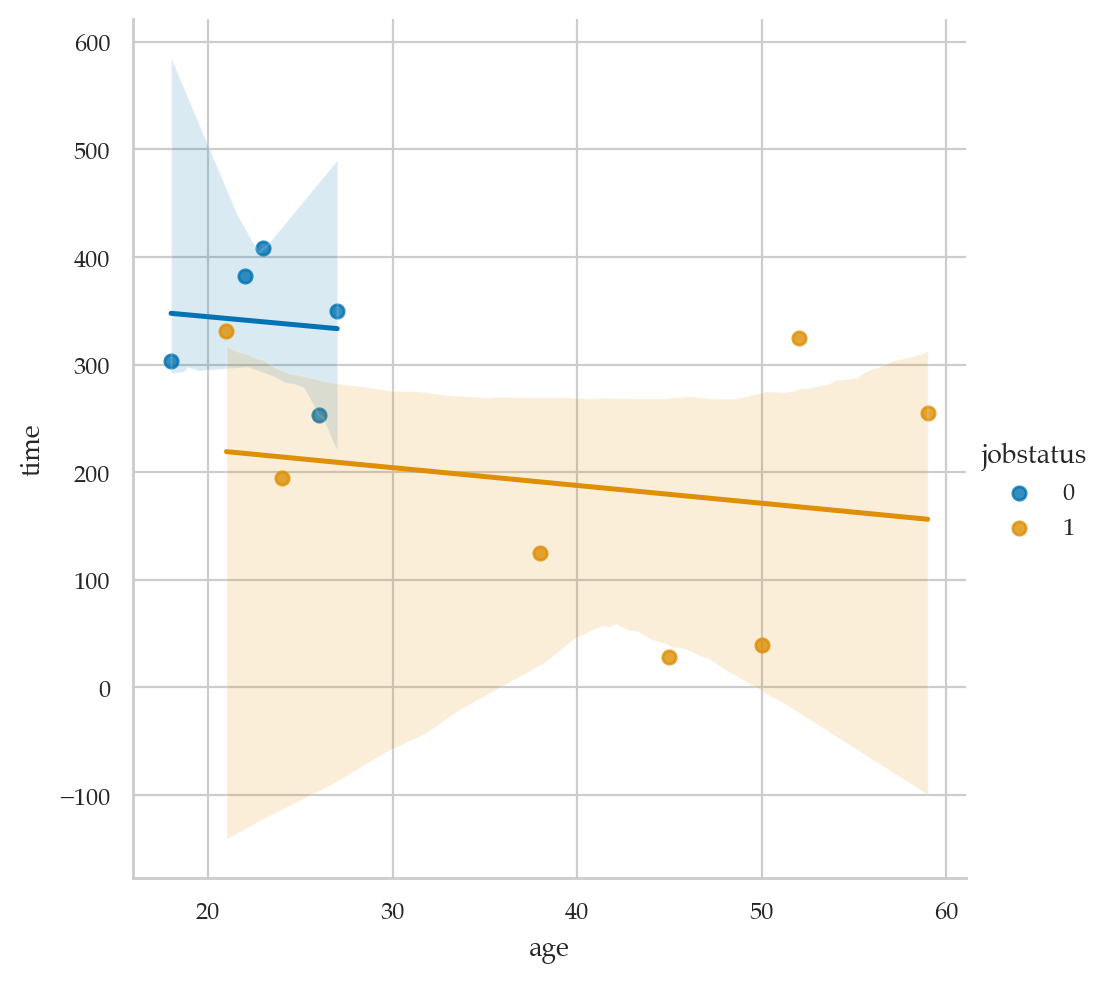

In [47]:
sns.lmplot(x="age", y="time", hue="jobstatus", data=players_full)

In [48]:
import statsmodels.formula.api as smf

model2 = smf.ols('time ~ 1 + age + C(jobstatus)', data=players_full)
result2 = model2.fit()
result2.params
# print(result2.summary().as_text())

Intercept            377.817172
C(jobstatus)[T.1]   -124.013781
age                   -1.650913
dtype: float64

#### Manual select subset with jobstatus 1

In [49]:
# import statsmodels.formula.api as smf

# players_job1 = players_full[players_full["jobstatus"]==1]
# model3 = smf.ols('time ~ 1 + age', data=players_job1)
# result3 = model3.fit()
# result3.summary()

### Example confoudouder  2

via https://stats.stackexchange.com/a/17338/62481

In [50]:
import numpy as np
from scipy.stats import uniform, randint

covariate = randint(0,2).rvs(100)
exposure  = uniform(0,1).rvs(100) +  0.3 * covariate
outcome   = 2.0 + 0.5*exposure + 0.25*covariate

# covariate, exposure, outcome
df2 = pd.DataFrame({
    "covariate":covariate,
    "exposure":exposure,
    "outcome":outcome
})

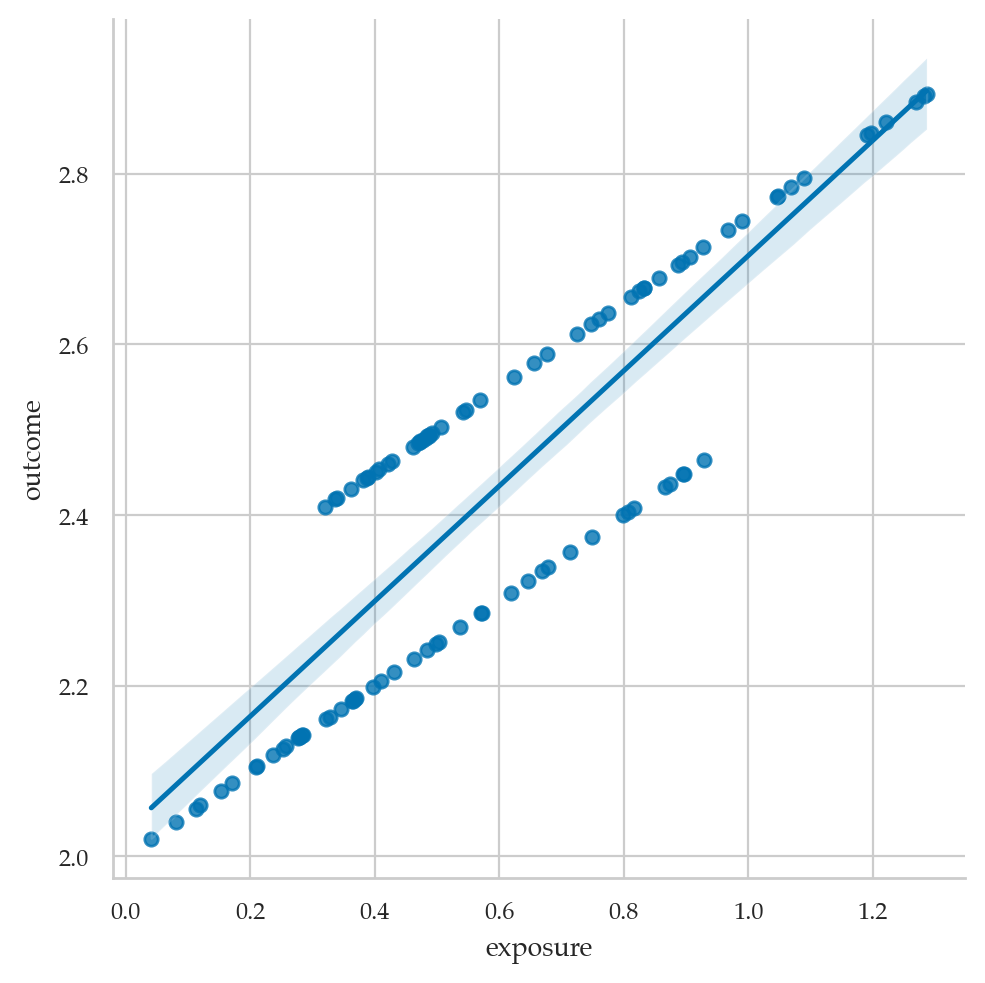

In [51]:
sns.lmplot(x="exposure", y="outcome", data=df2)

In [52]:
import statsmodels.formula.api as smf

model2a = smf.ols('outcome ~ exposure', data=df2)
result2a = model2a.fit()
# result2a.summary()
result2a.params

Intercept    2.029252
exposure     0.674851
dtype: float64

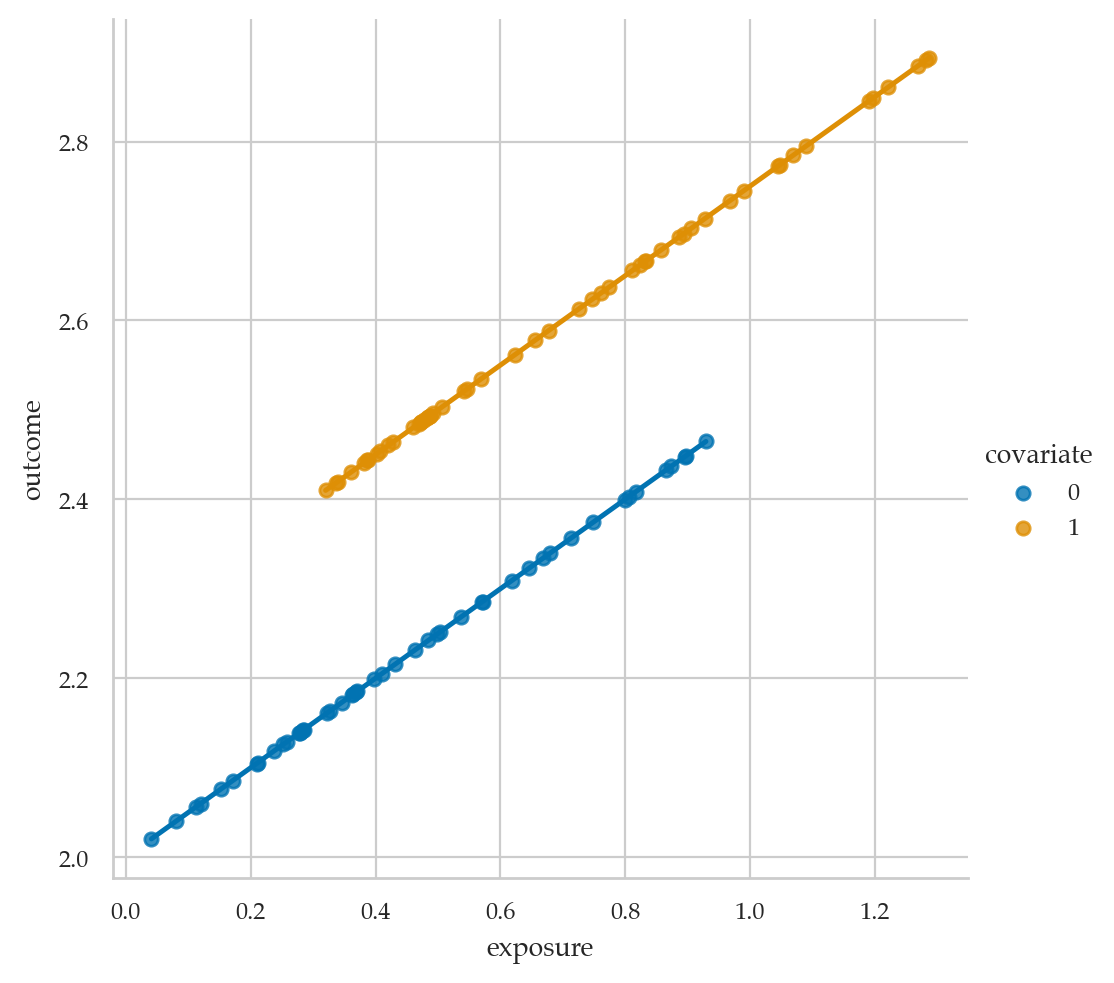

In [53]:
fg = sns.lmplot(x="exposure", y="outcome", hue="covariate", data=df2)

In [54]:
model2b = smf.ols('outcome ~ exposure + C(covariate)', data=df2)
result2b = model2b.fit()
# result2b.summary()
result2b.params

Intercept            2.00
C(covariate)[T.1]    0.25
exposure             0.50
dtype: float64

In [55]:
x = np.linspace(0,1.4)

m = result2b.params["exposure"]
b0 = result2b.params["Intercept"]
b1 = b0 + result2b.params["C(covariate)[T.1]"]

b0, b1

y0 = b0 + m*x
y1 = b1 + m*x
ax = fg.figure.axes[0]
sns.lineplot(x=x, y=y0, ax=ax, color="r")
sns.lineplot(x=x, y=y1, ax=ax, color="m")

<Axes: xlabel='exposure', ylabel='outcome'>

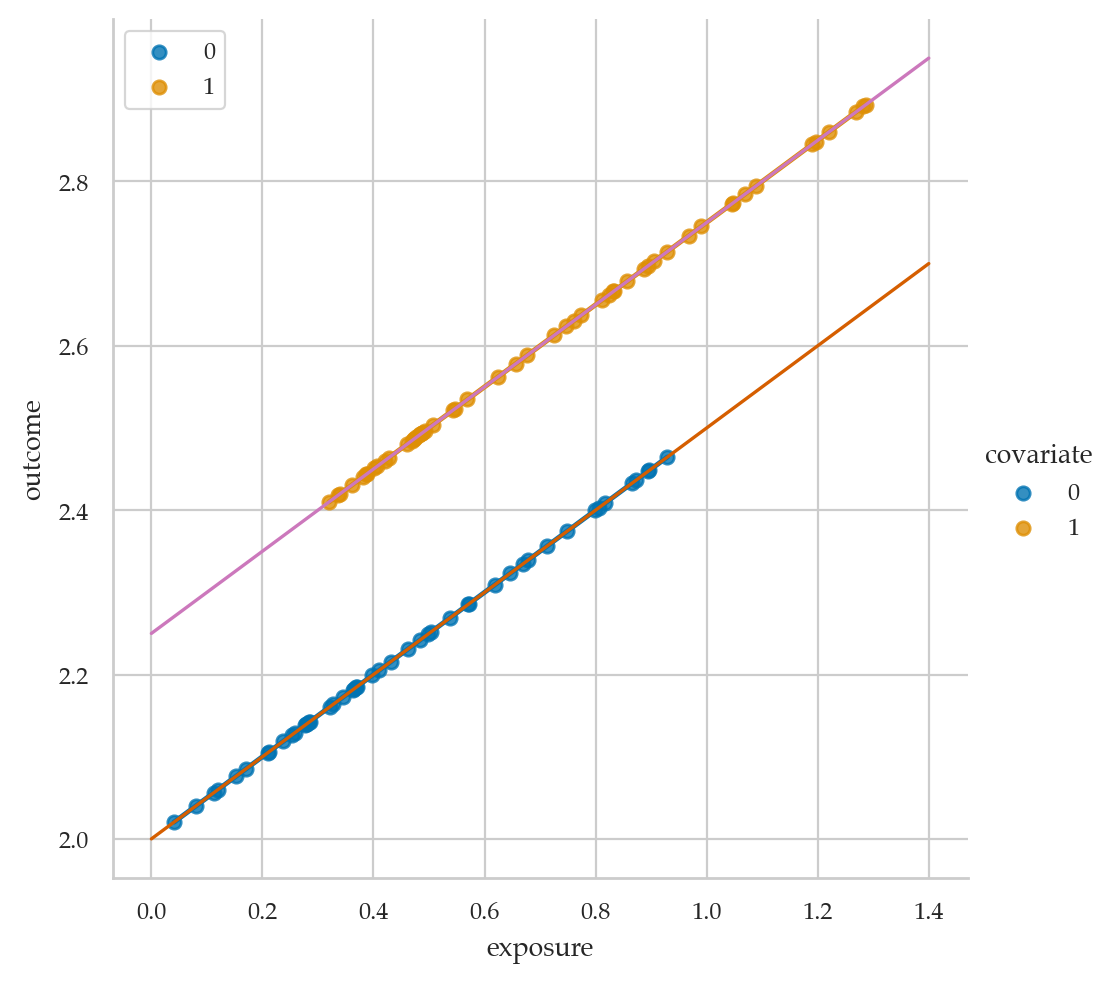

In [56]:
fg.figure

In [57]:
model2c = smf.ols('outcome ~ -1 + exposure*C(covariate)', data=df2)
result2c = model2c.fit()
result2c.summary()
# result2c.params

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.273e+31
Date:                Thu, 04 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:20:01   Log-Likelihood:                 3412.4
No. Observations:                 100   AIC:                            -6817.
Df Residuals:                      96   BIC:                            -6806.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
C(covariate)[0]                2.0000   1.15e-16   1.74e+16      0.000       2.000       2.000
C(covariate)[1]                2.2500   1.35e-16   1.66e+16      0.000       2.250       2.250
exposure                       0.5000    2.2e-16   2.27e+15      0.000       0.500       0.500
exposure:C(covariate)[T.1]          0   2.83e-16          0      1.000   -5.61e-16    5.61e-16
==============================================================================
Omnibus:                        1.057   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.589   Jarque-Bera (JB):                1.144
Skew:                           0.225   Prob(JB):                        0.564
Kurtosis:                       2.732   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# df = sns.load_dataset('iris')
# sns.regplot(x=df["sepal_length"], y=df["sepal_width"], line_kws={"color":"r","alpha":0.7,"lw":5})

### Random slopes and random intercepts

via https://patsy.readthedocs.io/en/latest/quickstart.html

You can even write interactions between categorical and numerical variables.
Here we fit two different slope coefficients for x1; one for the a1 group, and one for the a2 group:
`dmatrix("a:x1", data)`

This is what matches the seaborn plot when using `hue` as an extra variable

In [59]:
model2d = smf.ols('outcome ~ 1 + C(covariate) + C(covariate):exposure', data=df2)
result2d = model2d.fit()
# result2d.summary()
result2d.params

Intercept                   2.00
C(covariate)[T.1]           0.25
C(covariate)[0]:exposure    0.50
C(covariate)[1]:exposure    0.50
dtype: float64

In [60]:
import numpy as np
from scipy.stats import uniform, randint

covariate3 = randint(0,2).rvs(100)
exposure3  = uniform(0,1).rvs(100) +  0.3 * covariate
outcome3   = 2.0 + 0.25*covariate3 + (0.5 + 0.1*covariate3)*exposure3 
#                  \             /    \                  /
#                  different inst.      different slopes  

df3 = pd.DataFrame({
    "covariate":covariate3,
    "exposure":exposure3,
    "outcome":outcome3
})


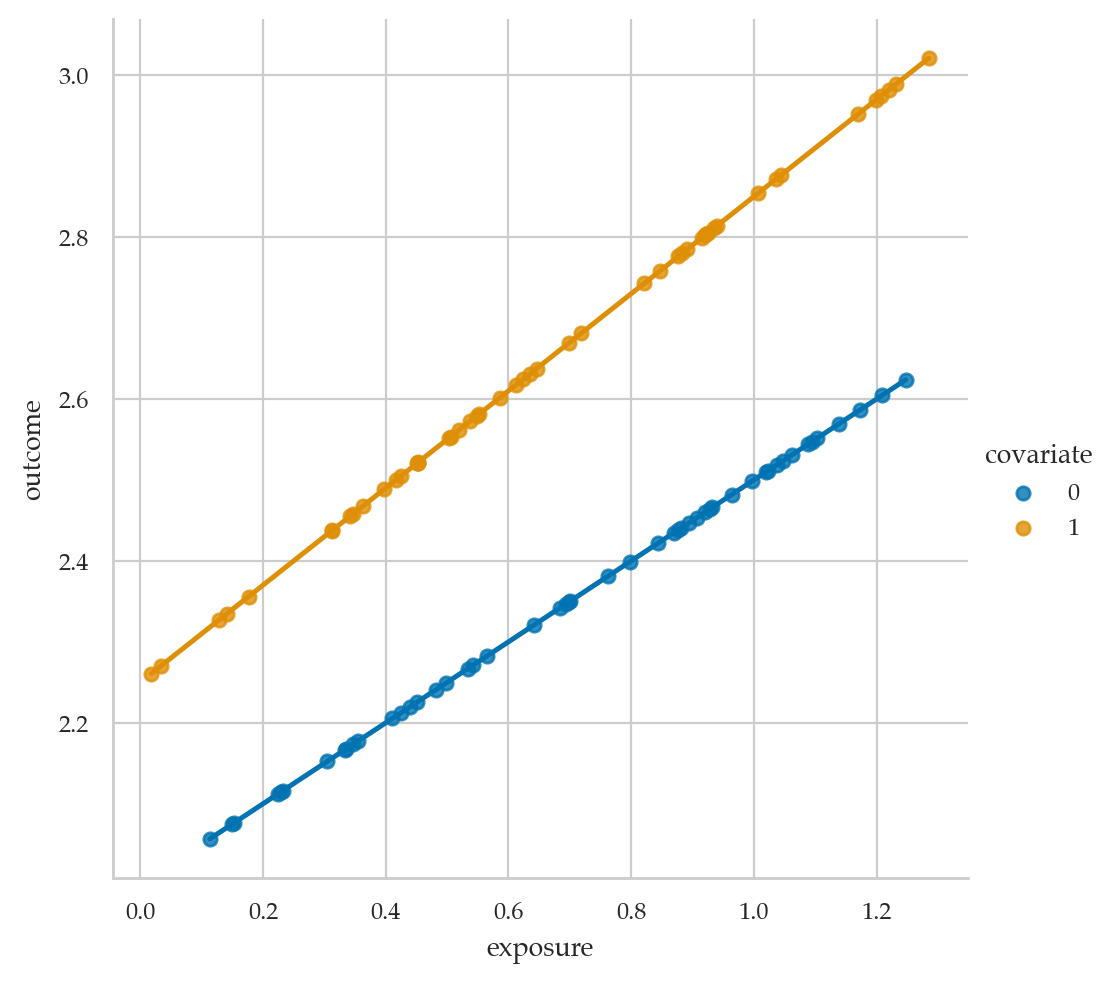

In [61]:
fg = sns.lmplot(x="exposure", y="outcome", hue="covariate", data=df3)

In [62]:
model3d = smf.ols('outcome ~ 1 + C(covariate) + C(covariate):exposure', data=df3)
result3d = model3d.fit()
result3d.params

Intercept                   2.00
C(covariate)[T.1]           0.25
C(covariate)[0]:exposure    0.50
C(covariate)[1]:exposure    0.60
dtype: float64

In [63]:
# ALT.
model3e = smf.ols('outcome ~ 0 + C(covariate) + C(covariate):exposure', data=df3)
result3e = model3e.fit()
result3e.params

C(covariate)[0]             2.00
C(covariate)[1]             2.25
C(covariate)[0]:exposure    0.50
C(covariate)[1]:exposure    0.60
dtype: float64

### Example N: campaign responses

via [logistic-regression-python-implementation.ipynb](./explorations/logistic-regression-python-implementation.ipynb)

see also [marketing-eda-stats-prediction-accuracy-100.ipynb](./explorations/marketing-eda-stats-prediction-accuracy-100.ipynb)

In [64]:
import pandas as pd
# data = pd.read_csv("/kaggle/input/marketing-campaign-positive-response-prediction/campaign_responses.csv")
campresp_raw = pd.read_csv("./explorations/data/campaign_responses.csv")
# campresp.drop('customer_id', axis=1, inplace=True)
campresp_raw.head(3)

,customer_id,age,gender,annual_income,credit_score,employed,marital_status,no_of_children,responded
0,1,35,Male,65000,720,Yes,Married,2,Yes
1,2,28,Female,45000,680,No,Single,0,No
2,3,42,Male,85000,750,Yes,Married,3,Yes


In [65]:
campresp = pd.DataFrame()
def standardize(column):
    return (column - column.mean())/column.std(ddof=0)

# standardize numerical columns
campresp["age"] = standardize(campresp_raw["age"])
campresp["annual_income"] = standardize(campresp_raw["annual_income"])
campresp["credit_score"] = standardize(campresp_raw["credit_score"])
campresp["no_of_children"] = standardize(campresp_raw["no_of_children"])

# copy over categorical
campresp["gender"] = campresp_raw["gender"]
campresp["employed"] = campresp_raw["employed"]
campresp["marital_status"] = campresp_raw["marital_status"]
campresp["responded"] = campresp_raw["responded"].replace({"Yes":1, "No":0})

campresp.head()

/var/folders/wc/2r44j8gs4gn56t1xtw5f6wlm0000gn/T/ipykernel_29046/1604395620.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  campresp["responded"] = campresp_raw["responded"].replace({"Yes":1, "No":0})


,age,annual_income,credit_score,no_of_children,gender,employed,marital_status,responded
0,-0.172859,-0.177936,0.014931,0.607457,Male,Yes,Married,1
1,-1.169337,-1.063659,-0.653970,-1.093422,Female,No,Single,0
2,0.823620,0.707788,0.516607,1.457896,Male,Yes,Married,1
3,-0.742275,-0.620797,-0.152294,-0.242983,Female,Yes,Single,0
4,1.535390,1.150650,1.185508,0.607457,Male,Yes,Married,1


In [66]:
# formula = "responded ~ 1 + age + C(gender) + annual_income + credit_score + C(employed) + C(marital_status) + no_of_children"
# lrcampresp = smf.logit(formula, data=campresp).fit(method="lbfgs")
# lrcampresp.params

In [67]:
# lrcampresp.model.exog.round(3)

In [68]:
# w = [ 0.17016481  0.06417441 -0.17534414  0.26848132  0.29103447  0.27035385
#   0.29485787], b = -0.005179325656765166
# 1.0

### Model comparison (CUT MATERIAL)

In [69]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [70]:
# load the doctors data set
doctors = pd.read_csv("../datasets/doctors.csv")

# fit the short model
formula2 = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula2, data=doctors).fit()

# fit long model with caffeine
formula2c = "score ~ 1 + alc + weed + exrc + caf"
lm2c = smf.ols(formula2c, data=doctors).fit()

# fit long model with useless varaible
formula2p = "score ~ 1 + alc + weed + exrc + permit"
lm2p = smf.ols(formula2p, data=doctors).fit()


# fit long model with hours
formula2h = "score ~ 1 + alc + weed + exrc + hours"
lm2h = smf.ols(formula2h, data=doctors).fit()

#### Lagrange multiplier test (optional)

In [71]:
# workaround to avoid bug
lm2_np = sm.OLS(lm2.model.endog, lm2.model.exog).fit()
lm2c_np = sm.OLS(lm2c.model.endog, lm2c.model.exog).fit()

# Lagrange Multiplier test to check short model
lm2c_np.compare_lm_test(lm2_np)

(12.643516756348614, 0.0003768703584529868, 1.0)

In [72]:
import pandas as pd
import statsmodels.formula.api as smf

doctors = pd.read_csv("../datasets/doctors.csv")
formula3 = "score ~ 1 + alc + weed + exrc + C(loc)"
lm3 = smf.ols(formula3, data=doctors).fit()

# HOW TO GET DESIGN MATRIX INFO
for key, vardict in lm3.model.data.design_info.factor_infos.items():
    print(key.name())
    print("type:", vardict.type)
    if vardict.type == "categorical":
        slicer = lm3.model.data.design_info.slice("C(loc)")
        colnames = lm3.model.data.design_info.column_names[slicer]
        print(colnames)
    print("")

alc
type: numerical

weed
type: numerical

exrc
type: numerical

C(loc)
type: categorical
['C(loc)[T.urb]']



In [73]:
# workaround to avoid RuntimeWarning: invalid value encountered in divide
# nzwdocs = doctors[doctors["weed"] != 0]
# zwdocs = doctors[doctors["weed"] == 0]
# n_subsample = int(0.4*len(zwdocs))
# np.random.seed(42)
# zwdocs_subsample = zwdocs.sample(n_subsample)
# idxs = np.concatenate((nzwdocs.index, zwdocs_subsample.index))
# sns.regplot(x=doctors["weed"][idxs], y=lm2.resid[idxs], lowess=True, scatter_kws={'s':8}, ax=axs[1])
# ALT.
# doctors_alt = doctors.loc[idxs]
# formula = "score ~ 1 + alc + weed + exrc"
# lm2_alt = smf.ols(formula, data=doctors_alt).fit()    
# plot_resid(lm2, "weed", lowess=True, ax=axs[1])

# Fixes instead by increasing `frac` to 0.72 (higher than default 2/3)

##### Manual calculations of leverage metric

In [74]:
mtcars = sm.datasets.get_rdataset("mtcars", "datasets").data

# Fit model using all data points
lmcars = smf.ols("mpg ~ hp", data=mtcars).fit()

# Design matrix
X = sm.add_constant(mtcars["hp"]).values

# Hat matrix
H = X @ np.linalg.inv(X.T @ X) @ X.T

# First element of the diagonal form the hat matrix
h0 = np.diag(H)[0]
print(f"{h0 = }")

# Linear model fit without the first data point
lmcars_no0 = smf.ols("mpg ~ hp", data=mtcars[1:]).fit()

# Prediction of yhat0 from the model without the first data point
yhat0_no0 = lmcars_no0.predict({"hp":mtcars.iloc[0]["hp"]})[0]
print(f"{yhat0_no0 = }")

# Alternative formula   h0 = 1 - r0 / r0_no0
r0 = lmcars.resid.iloc[0]          # residual from the full model 
r0_no0 = lmcars_no0.resid.iloc[0]  # residual from model w/o first point
h0 = 1 - r0/r0_no0
print(f"{h0 = }")

# Alternative formula for h0 via `statsmodels`
infl_cars = lmcars.get_influence()
h0 = infl_cars.hat_matrix_diag[0]
print(f"{h0 = }")

h0 = 0.04048626926227573
yhat0_no0 = 22.660997545626714
h0 = 0.040486269262266505
h0 = 0.040486269262275755


## Partial projection plots

#### Partial regression plot for the predictor `alc` 

In [3]:
import pandas as pd
import statsmodels.formula.api as smf

doctors = pd.read_csv("../datasets/doctors.csv")

formula = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula, data=doctors).fit()
lm2.params

b0, b_alc, b_weed, b_exrc = lm2.params
avg_weed = doctors["weed"].mean()
avg_exrc = doctors["exrc"].mean()
avg_weed, avg_exrc

(0.6282051282051282, 5.387820512820513)

In [4]:
# FIXME
int_alc = b0 + b_weed*avg_weed + b_exrc*avg_exrc
int_alc

69.33837903371315

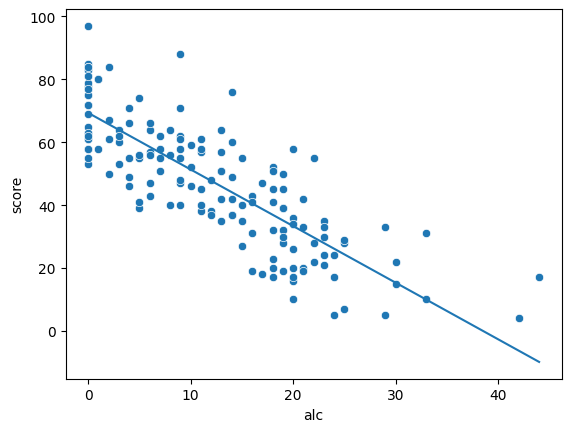

In [7]:
import numpy as np
import seaborn as sns

alcs = np.linspace(0, doctors["alc"].max())
scorehats_alc = int_alc + b_alc*alcs
sns.lineplot(x=alcs, y=scorehats_alc)
sns.scatterplot(data=doctors, x="alc", y="score");

alc intercept= 69.33837903371315 slope= -1.8001013152459384


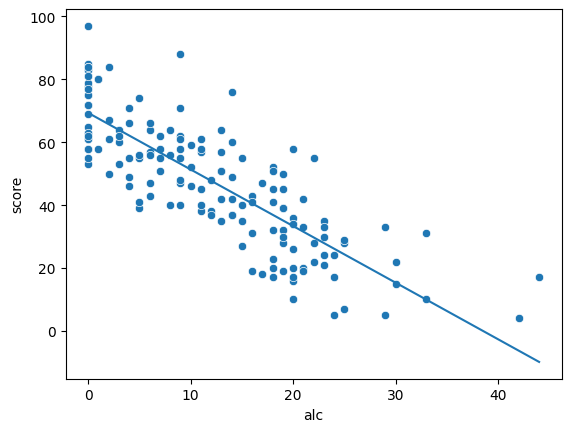

In [9]:
# ALT
from ministats import plot_projreg
plot_projreg(lm2, "alc");

#### OLD

In [18]:
# plot_lm_partial_old(lm2, "exrc")
# sns.scatterplot(data=doctors, x="exrc", y="score");

In [19]:
# # leave simplified version after split to figures only

# from ministats.plots import plot_lm_partial_old

# with plt.rc_context({"figure.figsize":(6.2,2)}):
#     fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
#     # alc
#     sns.scatterplot(data=doctors, x="alc", y="score", s=5, ax=ax1)
#     ax1.set_xticks([0,10,20,30,40])
#     plot_lm_partial_old(lm2, "alc", ax=ax1)
#     # weed
#     sns.scatterplot(data=doctors, x="weed", y="score", s=5, ax=ax2)
#     ax2.set_xticks([0,2,4,6,8,10])
#     plot_lm_partial_old(lm2, "weed", ax=ax2)
#     # exrc
#     sns.scatterplot(data=doctors, x="exrc", y="score", s=5, ax=ax3)
#     ax3.set_xticks([0,5,10,15,20])
#     plot_lm_partial_old(lm2, "exrc", ax=ax3)

#     filename = os.path.join(DESTDIR, "prediction_score_vs_alc_weed_exrc.pdf")
#     savefigure(plt.gcf(), filename)

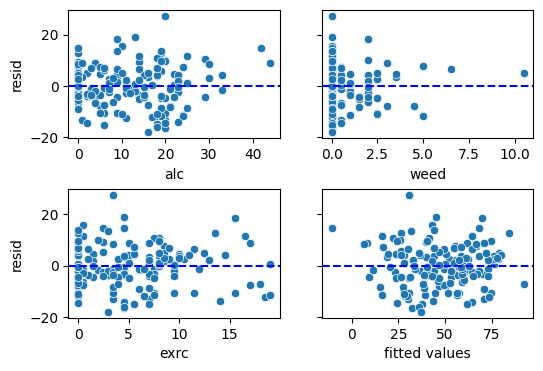

In [13]:
import os
import matplotlib.pyplot as plt

with plt.rc_context({"figure.figsize":(6,4)}):
    fig, axs_matrix = plt.subplots(2,2, sharey=True)
    fig.subplots_adjust(hspace=.4)
    axs = [ax for row in axs_matrix for ax in row]

    sns.scatterplot(x=doctors["alc"],   y=lm2.resid, ax=axs[0])
    axs[0].set_ylabel("resid")
    
    sns.scatterplot(x=doctors["weed"],  y=lm2.resid, ax=axs[1])
    
    sns.scatterplot(x=doctors["exrc"],  y=lm2.resid, ax=axs[2])
    axs[2].set_ylabel("resid")
    
    sns.scatterplot(x=lm2.fittedvalues, y=lm2.resid, ax=axs[3])
    axs[3].set_xlabel("fitted values")

    for ax in axs:
        ax.axhline(y=0, color="b", linestyle="dashed")

    # filename = os.path.join(DESTDIR, "sleep_scores_resid_vs_vars_2x2_panel.pdf")
    # savefigure(fig, filename)